In [1]:
import pandas as pd
import sys
import numpy as np
import random
from fuzzywuzzy import fuzz
import time
import psycopg2
import warnings
from scourgify import normalize_address_record
import networkx as nx
import pickle


import seaborn as sn
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,recall_score,accuracy_score,confusion_matrix
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression , LogisticRegressionCV
from sklearn.model_selection import GridSearchCV

C:\ProgramData\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
_user = ***
_dbname = ***
_host = ***
_secret_key = ***
_db_connection = psycopg2.connect(user = _user, dbname = _dbname, host = _host, password = _secret_key,port = ***)


In [3]:

def query_to_pandas(query,conn):
    '''
    Function to turn a hive query into a pandas data DataFrame
    '''
    with conn.cursor() as cur:
        cur.execute(query)
        colnames = [desc[0] for desc in cur.description]
        val=cur.fetchall()
        df=pd.DataFrame(data=val,columns=colnames)
        return(df)

In [4]:
features = ''' select * FROM datascience.final_with_bbf_onehot '''

df1 = query_to_pandas(features, _db_connection )


In [5]:
df1['has_made_cpe_in_lookahead'].value_counts()

0    133031
1      3689
Name: has_made_cpe_in_lookahead, dtype: int64

In [6]:
col_name =list(
['income',
 'home_value',
 'female',
 'marital_status_married',
 'marital_status_single',
 'dwelling_type_a',
 'dwelling_type_m',
 'dwelling_type_c',
 'dwelling_type_s',
 'dwelling_type_p',
 'dwelling_type_unknown',
 'credit_range',
 'investments',
 'credit_cards','male'
 ])

for i in col_name:
    df1[i] = df1[i].astype(int)

In [7]:
list(df1.columns)


df1=df1[['snapframe',
 'contact_id',
 'avg_days_btw_purchase',
 'days_since_last_order',
 'days_btw_reg_and_1storder',
 'state_northeast',
 'state_midwest',
 'state_south',
 'state_west','age',
 'last_order_revenue',
 'last_order_big4',
 'last_order_nonbig4',
 'last_order_university',
 'last_order_bill',
  'is_cpa',
 'first_order_revenue',
  'first_order_bill',
 'total_orders',
 'completed_orders',
 'cancelled_returned_orders',
 'direct_bill_orders',
 'nondirect_bill_orders',
 'has_made_db_order',
 'has_made_nondb_order',
 'made_big4_order',
 'made_non_big4_order',
 'made_university_orders',
 'big4_orders',
 'non_big4_orders',
 'university_orders',
 'discount_percentage',
  'number_of_orders_p36m',
  'number_of_orders_p30m',
 'number_of_orders_p24m',
 'number_of_orders_p18m',
 'number_of_orders_p12m',
 'number_of_orders_p6m',
 'number_of_orders_p3m',
 'total_revenue_p18m',
  'total_revenue_p24m',
  'total_revenue_p30m',
  'total_revenue_p36m',
 'total_revenue_p12m',
 'total_revenue_p6m',
 'total_revenue_p3m',
 'total_discount_p18m',
  'total_discount_p24m',
  'total_discount_p30m',
  'total_discount_p36m',
'total_discount_p12m',
 'total_discount_p6m',
 'courses_completed_p3m',
 'courses_completed_p6m',
 'courses_completed_p12m',
  'courses_completed_p24m',
  'courses_completed_p36m',
 'has_completed_course_p3m',
 'has_completed_course_p6m',
 'has_completed_course_p12m',
 'has_completed_course_p24m',
 'has_completed_course_p36m',
 'tenure_1st_order',
 'has_bought_exam_review',
 'has_bought_mcq',
 'has_bought_flashcards',
 'has_bought_textbook',
 'has_bought_final_review',
 'lsto_has_bought_exam_review',
 'lsto_has_bought_mcq',
 'lsto_has_bought_flashcards',
 'lsto_has_bought_textbook',
 'lsto_has_bought_final_review',
 'income',
 'home_value',
 'net_worth',
 'marital_status_married',
 'marital_status_single',
 'female',
 'dwelling_type_a',
 'dwelling_type_m',
 'dwelling_type_c',
 'dwelling_type_s',
 'dwelling_type_p',
 'dwelling_type_unknown',
 'credit_range',
 'investments',
 'credit_cards',
 'num_of_adults',
 'num_in_household',
 'mail_buyer',
 'magazine',
 'len_of_residence',
 'investments_own_mutual_funds_cds',
 'investments_own_stocks_or_bonds',
 'home_improvement',
 'hobby_crafts',
 'hobby_cooking_gourmet',
 'gardening',
 'food',
 'entertainment_enth',
 'gen_in_household',
 'religion_catholic',
 'religion_protestant',
 'religion_others',
 'collectors',
 'consumer_electronics',
 'travel',
 'reading_news_finance',
 'sports'  ,      
 'has_made_cpe_in_lookahead']]

In [8]:
df1_contact = df1[['snapframe','contact_id']]
df1_data = df1.loc[:,['avg_days_btw_purchase',
    'days_btw_reg_and_1storder',
 'days_since_last_order',
 'state_northeast',
 'state_midwest',
 'state_south',
 'state_west',
 'last_order_revenue',
 'last_order_bill',
 'is_cpa',
  'age',
  'first_order_revenue',
  'first_order_bill',
 'total_orders',
 'completed_orders',
 'cancelled_returned_orders',
 'has_made_db_order',
 'has_made_nondb_order',
 'made_big4_order',
 'made_non_big4_order',
 'made_university_orders',
 'discount_percentage',
 'number_of_orders_p24m',
  'number_of_orders_p36m',
 'number_of_orders_p30m',
 'number_of_orders_p18m',
 'number_of_orders_p12m',
 'number_of_orders_p6m',
 'number_of_orders_p3m',
  'tenure_1st_order',
  'total_revenue_p24m',
  'total_revenue_p30m',
  'total_revenue_p36m',
  'total_revenue_p18m',
 'total_revenue_p12m',
 'total_revenue_p6m',
 'total_revenue_p3m',
 'total_discount_p12m',
  'total_discount_p24m',
   'total_discount_p36m',
 'courses_completed_p12m',
  'courses_completed_p24m',
'courses_completed_p36m',
 'has_bought_exam_review',
 'has_bought_flashcards',
 'has_bought_textbook',
 'has_bought_final_review',
 'lsto_has_bought_exam_review',
 'lsto_has_bought_mcq',
 'lsto_has_bought_flashcards',
 'lsto_has_bought_textbook',
 'lsto_has_bought_final_review',
 'income',
 'home_value',
 'net_worth',
 'marital_status_married',
 'marital_status_single',
 'female',
 'dwelling_type_a',
 'dwelling_type_m',
 'dwelling_type_c',
 'dwelling_type_s',
 'dwelling_type_p',
 'dwelling_type_unknown',
 'credit_range',
 'investments',
 'credit_cards',
 'num_of_adults',
 'num_in_household',
 'mail_buyer',
 'magazine',
 'len_of_residence',
 'investments_own_mutual_funds_cds',
 'investments_own_stocks_or_bonds',
 'home_improvement',
 'hobby_crafts',
 'hobby_cooking_gourmet',
 'gardening',
 'food',
 'entertainment_enth',
 'gen_in_household',
 'religion_catholic',
 'religion_protestant',
 'religion_others',
 'collectors',
 'consumer_electronics',
 'travel',
 'reading_news_finance',
 'sports'      ,              
 'has_made_cpe_in_lookahead']]
    

In [9]:
rename_dict = {
  'days_btw_reg_and_1storder':'days_btw_registration_and_1storder',
  "last_order_bill": "last_order_direct_non-direct_bill_type", 
  'has_made_db_order':'has_made_direct_bill_order',
  "has_made_nondb_order": "has_made_non-direct_bill_order",
  "tenure_1st_order": 'tenure_from_1st_order-last_order',
  "lsto_has_bought_exam_review": 'has_bought_exam_review_in_last_order',
  'lsto_has_bought_mcq':'has_bought_mcq_in_last_order',
  "lsto_has_bought_flashcards":"has_bought_flashcards_in_last_order",
  "lsto_has_bought_final_review" : "has_bought_final_review_in_last_order",
  "lsto_has_bought_textbook" : "has_bought_textbook_in_last_order",
  "num_in_household" : "number_in_household",
  "len_of_residence" : "length_of_residence",
    'number_of_orders_p36m' : 'number_of_orders_past_36months',
 'number_of_orders_p30m' : "number_of_orders_past_30months",
  'number_of_orders_p24m' : 'number_of_orders_past_24months',
 'number_of_orders_p18m' : "number_of_orders_past_18months",
 'number_of_orders_p12m' : "number_of_orders_past_12months",
 'number_of_orders_p6m' : "number_of_orders_past_6months",
 'number_of_orders_p3m' : "number_of_orders_past_3months",
    'total_revenue_p36m' : "total_revenue_past_36months",
 'total_revenue_p30m' : "total_revenue_past_30months",
 'total_revenue_p24m' : "total_revenue_past_24months",
 'total_revenue_p18m' : "total_revenue_past_18months",
 'total_revenue_p12m' : "total_revenue_past_12months",
 'total_revenue_p6m' : "total_revenue_past_6months",
 'total_revenue_p3m' : "total_revenue_past_3months",
 'total_discount_p18m' : "total_discount_past_18months",
    'total_discount_p12m' : "total_discount_past_12months",
    'total_discount_p24m' : "total_discount_past_24months",
    'total_discount_p36m' : "total_discount_past_36months",
    'total_discount_p6m' : "total_discount_past_6months",
    'total_discount_p30m' : "total_discount_past_30months",
 'courses_completed_p3m' : "exams_passed_past_3months",
    'courses_completed_p6m' : "exams_passed_past_6months",
    'courses_completed_p12m' : "exams_passed_past_12months",
    'courses_completed_p24m' : "exams_passed_past_24months",
    'courses_completed_p36m' : "exams_passed_past_36months",
}

df1_data = df1_data.rename(columns=rename_dict)   

In [10]:
from sklearn.preprocessing import StandardScaler
features =['total_revenue_past_18months', 
           'income',
           'home_value',
           'net_worth', 
           'total_revenue_past_12months'  , 
           'total_revenue_past_24months' , 
           'total_revenue_past_30months' ,
           'total_revenue_past_36months' ,
           'total_revenue_past_6months',            
           'total_revenue_past_3months',   
           'total_discount_past_12months',
           'total_discount_past_24months',
           'total_discount_past_36months',
           'last_order_revenue',
           'first_order_revenue']
for i in features:
    df1_data[i] = StandardScaler().fit_transform(df1_data[[i]])


In [14]:
#divide train and test (initially for building the model)
X_train, X_test, y_train, y_test = train_test_split(df1_data.drop('has_made_cpe_in_lookahead',axis=1), 
           df1_data['has_made_cpe_in_lookahead'], test_size=0.30, 
            random_state=102)

In [15]:
#dividing positive and negative cases
train = pd.concat([X_train,y_train],axis=1)
train_pos = train[train['has_made_cpe_in_lookahead'] == 1]
train_neg = train[train['has_made_cpe_in_lookahead'] == 0]

In [16]:
len(train_pos),len(train_neg)

(2574, 93130)

In [17]:
from xgboost import XGBClassifier
models = []
for i in range(0,10):
    train_sample = pd.concat([train_pos.sample(2000),train_neg.sample(8000)],axis=0)
    train_X = train_sample.iloc[:,0:89]
    train_Y = train_sample.iloc[:,-1]
# fit model no training data
    gmb = XGBClassifier(learning_rate =0.05, n_estimators=250, max_depth=6,
         min_child_weight=1, gamma=0.4, subsample=1, colsample_bytree=1,
         objective= 'binary:logistic', nthread=4, scale_pos_weight=4, seed=27)
    gmb.fit(train_X, train_Y)
    models += [gmb]
    # save the model to disk
    pickle.dump(models[i],open('gmb_sm_'+str(i)+'.sav','wb'))


In [31]:
#for testing
models1 = []
pred1 = pd.DataFrame()
for i in range(0,10):
    loaded_model = pickle.load(open('gmb_sm_'+str(i)+'.sav', 'rb'))
    models1 += [loaded_model]
    y_pred = models1[i].predict_proba(X_test)[:,1]
    pred1 = pd.concat([pred1, pd.DataFrame(y_pred, columns=[i])], axis =1)

In [32]:
#averege of probab for test
pred1['avg'] = pred1.mean(axis=1)
pred1.head()

,0,1,2,3,4,5,6,7,8,9,avg
0,0.222184,0.111818,0.150506,0.094499,0.114401,0.057413,0.263800,0.164557,0.078000,0.137660,0.139484
1,0.118625,0.254093,0.174560,0.338414,0.103858,0.244445,0.185716,0.200192,0.203986,0.148991,0.197288
2,0.222620,0.235629,0.210500,0.208296,0.102701,0.312953,0.159828,0.388189,0.323041,0.164589,0.232834
3,0.034858,0.015291,0.025254,0.040494,0.031758,0.027924,0.040887,0.034104,0.020384,0.043405,0.031436
4,0.033247,0.105049,0.137308,0.073266,0.086128,0.163065,0.067432,0.070725,0.088014,0.117864,0.094210


In [ ]:
## Accuracy Metrics

In [34]:
roc_auc_score(y_test,pred1['avg'])

0.8325255118525976

In [35]:
y_predictions= [1 if i > 0.5 else 0 for i in pred1['avg']]

In [36]:
accuracy = accuracy_score(y_test,y_predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 81.44%


In [29]:

precision = precision_score(y_test,y_predictions)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test,y_predictions )
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)


Precision: 0.087268
Recall: 0.711211


In [56]:
print(classification_report(y_test,y_predictions))

              precision    recall  f1-score   support

           0       0.99      0.79      0.88     39900
           1       0.09      0.75      0.16      1116

    accuracy                           0.78     41016
   macro avg       0.54      0.77      0.52     41016
weighted avg       0.97      0.78      0.86     41016



In [37]:
pred2 = pd.concat([y_test.reset_index()['has_made_cpe_in_lookahead'],pred1['avg']], axis =1)
pred2.sort_values('avg',inplace = True)
import numpy as np
my_frames = np.array_split(pred2, 10)
decile_df = pd.DataFrame(columns = ["total","bucket","is_cpe","is_not_cpe","hit_rate"])
for i in range(0,10):
    frame = my_frames[i]
    bucket = str(frame['avg'].min())+'-'+str(frame['avg'].max())
    total = len(frame)
    is_cpe = frame['has_made_cpe_in_lookahead'].sum()
    is_not_cpe = total - is_cpe
    hitrate = is_cpe / is_not_cpe
    bucket = str(round(frame['avg'].min(),4))+'-'+str(round(frame['avg'].max(),4))
    metrice = [total,bucket,is_cpe,is_not_cpe,hitrate]
    a_series = pd.Series(metrice, index = decile_df.columns)
    decile_df = decile_df.append(a_series, ignore_index=True)    
decile_df.to_csv('model1_decile.csv')
decile_df

,total,bucket,is_cpe,is_not_cpe,hit_rate
0,4102,0.0106-0.0701,8,4094,0.001954
1,4102,0.0701-0.1162,7,4095,0.001709
2,4102,0.1163-0.1675,13,4089,0.003179
3,4102,0.1675-0.2232,25,4077,0.006132
4,4102,0.2232-0.2837,42,4060,0.010345
5,4102,0.2837-0.3495,56,4046,0.013841
6,4101,0.3496-0.4174,84,4017,0.020911
7,4101,0.4174-0.4956,129,3972,0.032477
8,4101,0.4957-0.5958,215,3886,0.055327
9,4101,0.5959-0.9315,536,3565,0.150351


In [79]:
###SHAPLEY CHARTS

invalid value encountered in true_divide
invalid value encountered in true_divide


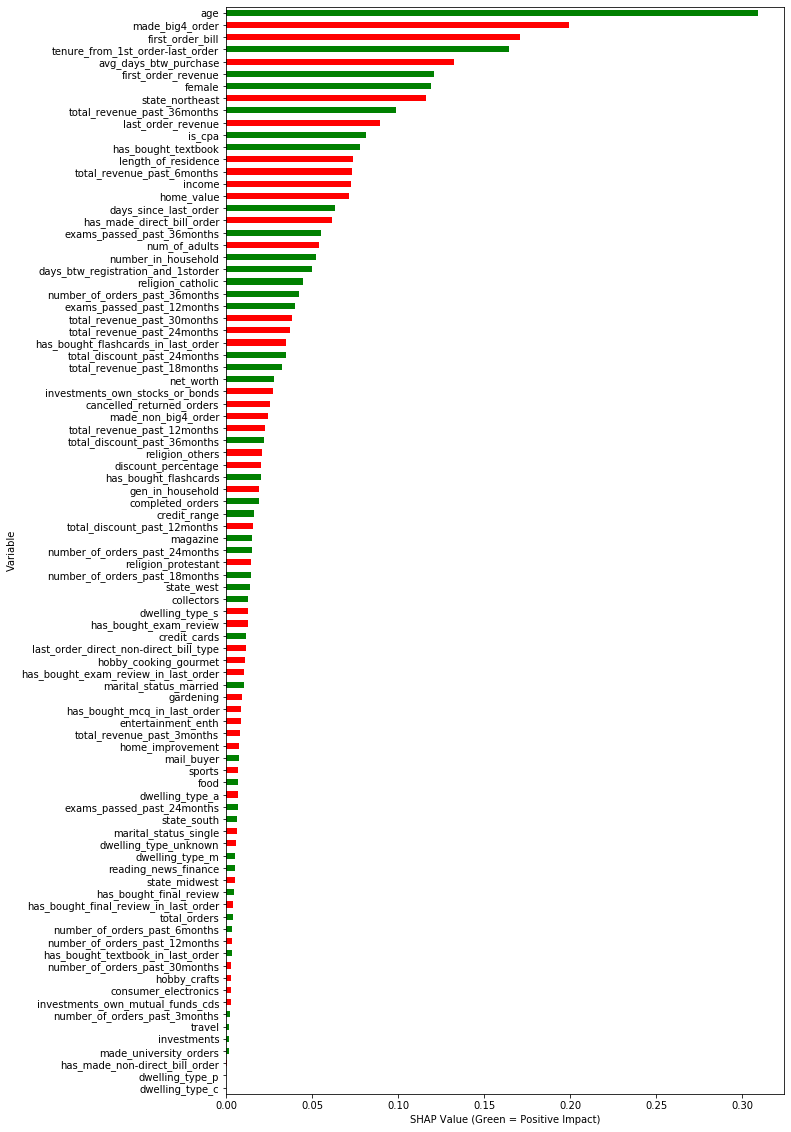

In [38]:
import shap
shap_values = shap.TreeExplainer(models[2]).shap_values(X_test)

def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'green','red')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(10,20),legend=False)
    ax.set_xlabel("SHAP Value (Green = Positive Impact)")
    
ABS_SHAP(shap_values,X_test)

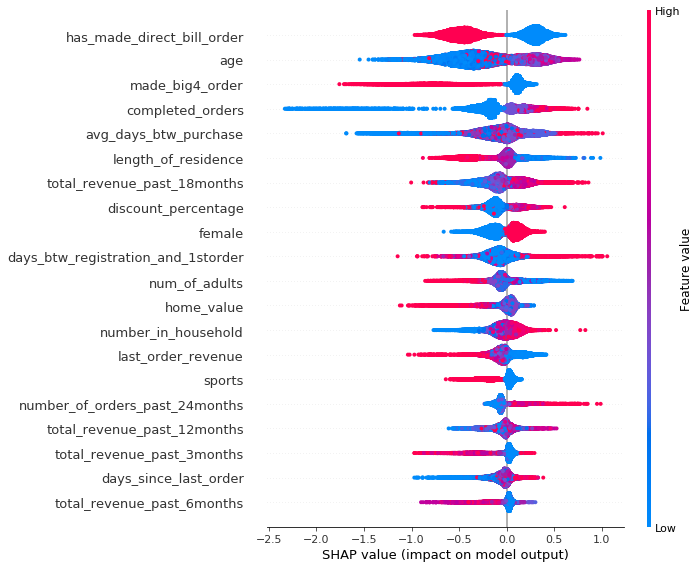

In [60]:

shap.summary_plot(shap_values, X_test)

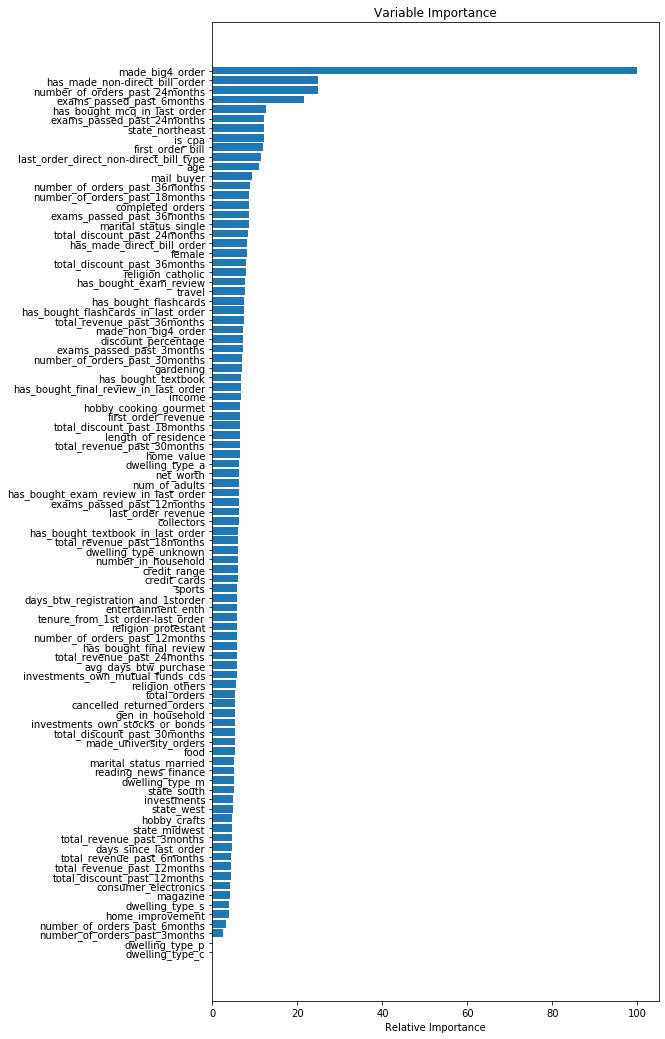

In [116]:
feature_importance = models[0].feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(8, 18))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, train_X.keys()[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [48]:
#n estimator tuning
#Choose all predictors except target & IDcols
param_test1 = {'n_estimators':range(290,400,10),'learning_rate':[0.15]}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1,max_depth=5,colsample_bytree=0.8,min_child_weight = 1,
                                                scale_pos_weight = 1,subsample=0.8,random_state=10,booster='gbtree'), 
param_grid = param_test1, scoring='f1',n_jobs=1,iid=False, cv=2)
gsearch1.fit(train_X,train_Y)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'mean_fit_time': array([16.28569281, 16.56080008, 17.49631536, 18.3551544 , 18.07152116,
         19.19914472, 17.96455216, 19.85574996, 18.65472221, 21.22249162,
         22.11852288]),
  'std_fit_time': array([1.04978549, 0.99496031, 0.33609354, 1.12079751, 0.86205566,
         0.35315621, 2.32604194, 0.23240411, 0.20231509, 0.6870836 ,
         1.55891633]),
  'mean_score_time': array([0.1053952 , 0.16462088, 0.05399692, 0.05708706, 0.08215642,
         0.08938277, 0.0631969 , 0.11471307, 0.11515498, 0.1286931 ,
         0.14412808]),
  'std_score_time': array([0.00974953, 0.00243473, 0.00200427, 0.00236475, 0.01765084,
         0.01878941, 0.0127306 , 0.0133146 , 0.0361793 , 0.04487729,
         0.07788444]),
  'param_learning_rate': masked_array(data=[0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15,
                     0.15, 0.15],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False],
         fill_value='?'

In [31]:
##learning rate = 0.1,estimators = 220 
##tuning for max_depth and min_child_weight

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.3, n_estimators=440, max_depth=6,
 min_child_weight=1, gamma=0, subsample=1, colsample_bytree=1,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='f1',n_jobs=1,iid=False, cv=2)
gsearch1.fit(train_X,train_Y)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'mean_fit_time': array([ 1.93743193,  2.08474755,  1.45771468,  4.29456341,  2.31506586,
          3.04692686,  3.92268741,  3.05037475,  4.66155815,  6.59540582,
          3.18147409, 10.15305853]),
  'std_fit_time': array([0.35137022, 0.58002973, 0.03608   , 1.97161853, 0.10393286,
         0.8832947 , 1.1091212 , 0.28870654, 1.93533206, 0.21824765,
         0.29416144, 5.07518578]),
  'mean_score_time': array([0.03118348, 0.03137863, 0.0311743 , 0.05492496, 0.04700863,
         0.05662811, 0.0548445 , 0.04697835, 0.05461657, 0.04695404,
         0.0469923 , 0.06258309]),
  'std_score_time': array([2.09808350e-05, 2.48551369e-04, 1.58548355e-05, 7.94720650e-03,
         1.07288361e-06, 9.64939594e-03, 7.38608837e-03, 2.30073929e-05,
         7.68053532e-03, 1.22785568e-05, 2.28881836e-05, 1.55771971e-02]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     Fal

In [70]:
gsearch2b.cv_results_, gsearch2b.best_params_, gsearch2b.best_score_

({'mean_fit_time': array([5.29872632, 2.96463323, 5.98690391, 5.29053187]),
  'std_fit_time': array([0.41997051, 0.03115129, 1.39982581, 2.13557005]),
  'mean_score_time': array([0.05418944, 0.04853773, 0.05404437, 0.05722415]),
  'std_score_time': array([0.00532484, 0.00151038, 0.00036776, 0.01056993]),
  'param_min_child_weight': masked_array(data=[6, 8, 10, 12],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'min_child_weight': 6},
   {'min_child_weight': 8},
   {'min_child_weight': 10},
   {'min_child_weight': 12}],
  'split0_test_score': array([0.43727599, 0.41877256, 0.43529412, 0.41707317]),
  'split1_test_score': array([0.38313253, 0.3764988 , 0.38246041, 0.38709677]),
  'mean_test_score': array([0.41020426, 0.39763568, 0.40887727, 0.40208497]),
  'std_test_score': array([0.02707173, 0.02113688, 0.02641685, 0.0149882 ]),
  'rank_test_score': array([1, 4, 2, 3])},
 {'min_child_weight': 6},
 0.4102042578917821

In [91]:
#Max Depth 
lr_list = range(3,10,2)


for depth in lr_list:
    gb = XGBClassifier( n_estimators= 100, max_depth=depth,
        min_child_weight= 1, gamma=0.1, subsample= 1, colsample_bytree= 1,
        objective= 'binary:logistic',learning_rate= 0.05,scale_pos_weight = 4,seed = 27,nthread = 4 )
    gb.fit(train_X, train_Y)
    train_predprob = gb.predict_proba(train_X)[:,1]
    test_predprob = gb.predict_proba(X_test)[:,1]
    test_valid = [1 if i > 0.50 else 0 for i in test_predprob]

    print("max_depth: ", depth)
    print("Accuracy score (test): {0:.3f}".format(roc_auc_score(y_test, test_predprob)))
    print("Accuracy score (train): {0:.3f}".format(roc_auc_score(train_Y, train_predprob)))
    print(classification_report(y_test,test_valid))
    
    
    
    


max_depth:  3
Accuracy score (test): 0.809
Accuracy score (train): 0.839
              precision    recall  f1-score   support

           0       0.99      0.71      0.83     23553
           1       0.05      0.74      0.10       501

    accuracy                           0.71     24054
   macro avg       0.52      0.73      0.46     24054
weighted avg       0.97      0.71      0.81     24054

max_depth:  5
Accuracy score (test): 0.811
Accuracy score (train): 0.924
              precision    recall  f1-score   support

           0       0.99      0.75      0.86     23553
           1       0.06      0.71      0.11       501

    accuracy                           0.75     24054
   macro avg       0.53      0.73      0.48     24054
weighted avg       0.97      0.75      0.84     24054

max_depth:  7
Accuracy score (test): 0.821
Accuracy score (train): 0.986
              precision    recall  f1-score   support

           0       0.99      0.81      0.89     23553
           1      

In [ ]:
#Learning Rate tuning
lr_list = range(3,10,2)


for depth in lr_list:
    gb = XGBClassifier( n_estimators= 100, max_depth=depth,
        min_child_weight= 1, gamma=0.1, subsample= 1, colsample_bytree= 1,
        objective= 'binary:logistic',learning_rate= 0.05,scale_pos_weight = 4,seed = 27,nthread = 4 )
    gb.fit(train_X, train_Y)
    train_predprob = gb.predict_proba(train_X)[:,1]
    test_predprob = gb.predict_proba(X_test)[:,1]
    test_valid = [1 if i > 0.50 else 0 for i in test_predprob]

    print("max_depth: ", depth)
    print("Accuracy score (test): {0:.3f}".format(roc_auc_score(y_test, test_predprob)))
    print("Accuracy score (train): {0:.3f}".format(roc_auc_score(train_Y, train_predprob)))
    print(classification_report(y_test,test_valid))
    
    
    
    


In [96]:
#alpha Tuning
reg_lambda=[0, 0.001, 0.005, 0.01, 0.05]


for lambda1 in reg_lambda:
    gb = XGBClassifier( n_estimators= 100, max_depth=depth,
        min_child_weight= 1, gamma=0.1, subsample= 1, colsample_bytree= 1,reg_lambda = lambda1,
        objective= 'binary:logistic',learning_rate= 0.05,scale_pos_weight = 4,seed = 27,nthread = 4 )
    gb.fit(train_X, train_Y)
    train_predprob = gb.predict_proba(train_X)[:,1]
    test_predprob = gb.predict_proba(X_test)[:,1]
    test_valid = [1 if i > 0.50 else 0 for i in test_predprob]

    print("reg alpha: ", alpha)
    print("Accuracy score (test): {0:.3f}".format(roc_auc_score(y_test, test_predprob)))
    print("Accuracy score (train): {0:.3f}".format(roc_auc_score(train_Y, train_predprob)))
    print(classification_report(y_test,test_valid))
    
    
    
    


reg alpha:  0.05
Accuracy score (test): 0.817
Accuracy score (train): 0.999
              precision    recall  f1-score   support

           0       0.99      0.86      0.92     23553
           1       0.08      0.59      0.14       501

    accuracy                           0.85     24054
   macro avg       0.54      0.72      0.53     24054
weighted avg       0.97      0.85      0.90     24054

reg alpha:  0.05
Accuracy score (test): 0.818
Accuracy score (train): 0.999
              precision    recall  f1-score   support

           0       0.99      0.86      0.92     23553
           1       0.08      0.58      0.14       501

    accuracy                           0.86     24054
   macro avg       0.54      0.72      0.53     24054
weighted avg       0.97      0.86      0.90     24054

reg alpha:  0.05
Accuracy score (test): 0.824
Accuracy score (train): 0.999
              precision    recall  f1-score   support

           0       0.99      0.86      0.92     23553
         

In [98]:
###Gamma Tuning

gamma = [i/10.0 for i in range(0,5)]

for gam in gamma:
    gb = XGBClassifier( n_estimators= 100, max_depth=depth,
        min_child_weight= 1, gamma= gam , subsample= 1, colsample_bytree= 1,
        objective= 'binary:logistic',learning_rate= 0.05,scale_pos_weight = 4,seed = 27,nthread = 4 )
    gb.fit(train_X, train_Y)
    train_predprob = gb.predict_proba(train_X)[:,1]
    test_predprob = gb.predict_proba(X_test)[:,1]
    test_valid = [1 if i > 0.50 else 0 for i in test_predprob]

    print("reg alpha: ", gam)
    print("Accuracy score (test): {0:.3f}".format(roc_auc_score(y_test, test_predprob)))
    print("Accuracy score (train): {0:.3f}".format(roc_auc_score(train_Y, train_predprob)))
    print(classification_report(y_test,test_valid))
    
    

reg alpha:  0.0
Accuracy score (test): 0.823
Accuracy score (train): 0.999
              precision    recall  f1-score   support

           0       0.99      0.85      0.91     23553
           1       0.08      0.60      0.14       501

    accuracy                           0.84     24054
   macro avg       0.53      0.72      0.53     24054
weighted avg       0.97      0.84      0.90     24054

reg alpha:  0.1
Accuracy score (test): 0.824
Accuracy score (train): 0.999
              precision    recall  f1-score   support

           0       0.99      0.85      0.91     23553
           1       0.08      0.60      0.14       501

    accuracy                           0.84     24054
   macro avg       0.53      0.73      0.53     24054
weighted avg       0.97      0.84      0.90     24054

reg alpha:  0.2
Accuracy score (test): 0.823
Accuracy score (train): 0.999
              precision    recall  f1-score   support

           0       0.99      0.85      0.91     23553
           1

In [ ]:
##Shapley Modelling Examples(Low , Medium and High Performing)

In [39]:
shap_df = pd.DataFrame(shap_values[:,:], columns = X_test.columns, index = X_test.index)
shap_df.round(2)
pred3 = pd.concat([y_test.reset_index(),pred1['avg']], axis =1).set_index('index')
pred3.sort_values('avg',inplace = True)
my_frames = np.array_split(pred3, 10)

In [49]:
shap_dec = pd.merge(shap_df, my_frames[9], left_index=True, right_index=True)

In [50]:
shap_dec.to_csv("Model_1_shap_high_performance_update.csv")
shap_dec

,avg_days_btw_purchase,days_btw_registration_and_1storder,days_since_last_order,state_northeast,state_midwest,state_south,state_west,last_order_revenue,last_order_direct_non-direct_bill_type,is_cpa,...,religion_catholic,religion_protestant,religion_others,collectors,consumer_electronics,travel,reading_news_finance,sports,has_made_cpe_in_lookahead,avg
98064,0.042328,0.004346,-0.019791,0.056147,-0.000597,0.006607,-0.002250,-0.227499,-0.000226,-0.073983,...,-0.005239,-0.012753,0.002544,-0.010855,-0.001043,-0.000291,-0.000342,-0.025120,0,0.609489
124111,0.020725,0.141424,0.038254,0.072954,0.000950,-0.013550,0.036635,-0.018637,-0.026196,-0.031170,...,-0.014338,0.003130,-0.082083,-0.002519,-0.000822,-0.003604,0.003286,0.012614,1,0.700941
109243,-0.164971,-0.067854,0.077129,0.050130,-0.007302,-0.002644,-0.004247,0.077412,-0.002260,-0.100113,...,0.069366,-0.007321,0.012984,0.034333,-0.000341,-0.000297,-0.001142,-0.000109,1,0.639393
60631,-0.008196,0.009683,0.014491,0.080038,-0.000252,0.007080,-0.006109,0.164880,-0.001593,-0.073780,...,-0.027373,-0.006780,0.009179,-0.017603,0.000152,0.000083,-0.001649,-0.003620,0,0.728331
62245,-0.342467,0.009794,0.026329,0.104303,-0.011725,-0.007060,0.002313,-0.108499,-0.000550,0.549236,...,-0.027755,-0.001631,0.008610,-0.012099,-0.001241,-0.001383,0.002797,-0.000067,0,0.713171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15780,0.177954,0.008216,0.038325,0.071418,-0.004463,-0.003345,-0.005186,-0.174384,-0.002466,-0.064148,...,-0.018867,0.002000,0.001175,-0.011411,-0.000537,-0.001375,-0.001339,0.000301,0,0.658045
85846,-0.004631,0.135401,-0.102719,0.058655,0.002004,-0.005351,0.017231,0.102228,-0.001280,0.697418,...,0.001607,-0.001611,0.034508,-0.003673,0.000968,-0.002012,-0.004640,-0.000064,1,0.931452
88570,-0.064210,-0.013792,0.133134,0.077948,-0.000758,-0.006157,-0.004926,0.116633,-0.000620,-0.066789,...,-0.026807,-0.001411,0.009672,-0.018287,-0.001739,-0.001323,-0.001955,-0.001587,0,0.622256
102022,0.196226,-0.031280,0.282132,0.081090,-0.000685,-0.003787,0.009027,0.076232,-0.000575,-0.090475,...,-0.035871,0.005004,0.018033,-0.005066,-0.003366,0.000106,-0.002187,-0.001004,0,0.606568


In [126]:
df1_contact

,snapframe,contact_id
0,2020-01-01,0030Z00003WJ9go
1,2019-01-01,0030Z00003IDOv6
2,2018-07-01,0030Z00003DIEIM
3,2019-07-01,003310000300uQg
4,2019-07-01,0030Z00003EGEGO
...,...,...
80123,2020-01-01,0030Z00003SOsQw
80124,2019-07-01,0030Z00003SOsQw
80125,2019-01-01,0030Z00003EGBL1
80126,2018-07-01,0030Z00003EGBL1


In [145]:
print(df1.loc[10933])

snapframe                         2019-07-01
contact_id                   0030Z00003DKPER
avg_days_btw_purchase                    102
days_since_last_order                    191
days_btw_reg_and_1storder                515
                                  ...       
consumer_electronics                       0
travel                                     1
reading_news_finance                       0
sports                                     0
has_made_cpe_in_lookahead                  0
Name: 10933, Length: 98, dtype: object


In [54]:
df1_contact.loc[100807]


snapframe          2019-01-01
contact_id    003310000371HSE
Name: 100807, dtype: object